In [1]:
import pandas as pd
import numpy as np

In [2]:
all_preds = pd.read_csv("predictions/initial_all_preds.csv")
all_preds.head(20)

,Rank,Name,Pos,proj_fpoints
0,1.0,Shohei Ohtani,DH,523.326236
1,2.0,Juan Soto,OF,495.032689
2,3.0,Zack Wheeler,SP,485.404123
3,4.0,Tarik Skubal,SP,484.581049
4,5.0,Bobby Witt Jr.,SS,478.107152
5,6.0,Aaron Judge,OF,465.511762
6,7.0,Jose Ramirez,3B,460.083944
7,8.0,Chris Sale,SP,454.918572
8,9.0,Paul Skenes,SP,453.792118
9,10.0,Logan Gilbert,SP,453.762465


In [3]:
## Taking top 400 players - below that are irrelevant
all_preds_400 = all_preds.head(300)

In [ ]:
## Getting positional average and standard deviation:
# Split positions and explode the dataframe
all_preds_400_exploded = all_preds_400.assign(Pos=all_preds_400['Pos'].str.split('/')).explode('Pos')
all_preds_400_exploded.loc[:, "Pos"] = all_preds_400_exploded.loc[:, "Pos"].str.strip()
all_preds_400_exploded["Pos"].unique()

array(['DH', 'OF', 'SP', 'SS', '3B', '1B', '2B', 'RP', 'C'], dtype=object)

In [5]:
# Calculate mean and standard deviation for each position
pos_stats = all_preds_400_exploded.groupby('Pos')['proj_fpoints'].agg(['mean', 'std']).reset_index()
pos_stats

,Pos,mean,std
0,1B,320.966444,53.658769
1,2B,294.753232,47.445885
2,3B,303.025191,66.061221
3,C,272.308813,39.282032
4,DH,325.392542,122.331718
5,OF,306.190012,62.676670
6,RP,272.965192,40.412205
7,SP,327.490751,67.264471
8,SS,317.604818,64.341608


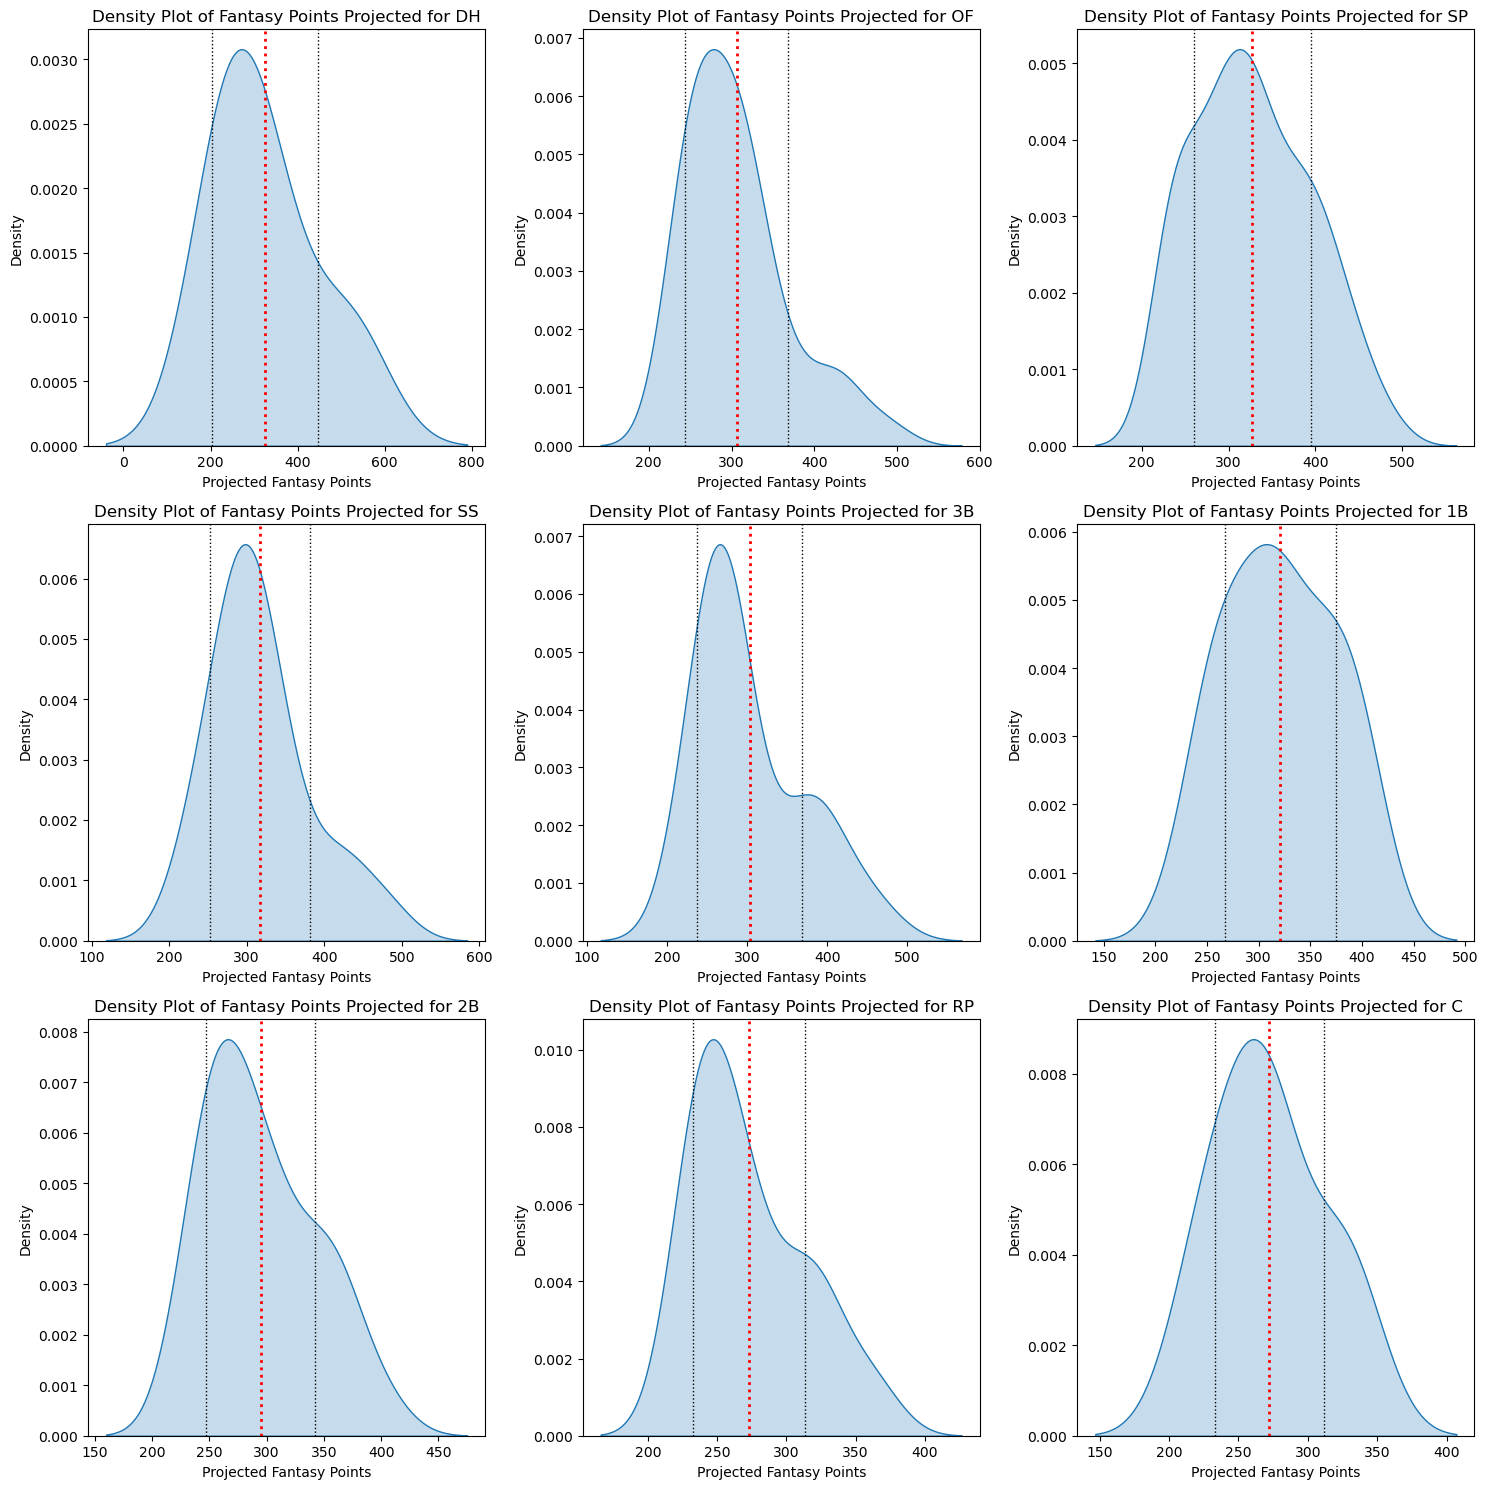

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Get unique positions
positions = all_preds_400_exploded['Pos'].unique()


num_positions = len(positions)
num_cols = 3
num_rows = (num_positions + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, pos in enumerate(positions):
    subset = all_preds_400_exploded[all_preds_400_exploded['Pos'] == pos]
    sns.kdeplot(subset['proj_fpoints'], shade=True, ax=axes[i])
    mean = pos_stats[pos_stats['Pos'] == pos]['mean'].values[0]
    std = pos_stats[pos_stats['Pos'] == pos]['std'].values[0]
    
    axes[i].axvline(mean, color='red', linestyle='dotted', linewidth=2)
    axes[i].axvline(mean + std, color='black', linestyle='dotted', linewidth=1)
    axes[i].axvline(mean - std, color='black', linestyle='dotted', linewidth=1)
    axes[i].set_title(f'Density Plot of Fantasy Points Projected for {pos}')
    axes[i].set_xlabel('Projected Fantasy Points')
    axes[i].set_ylabel('Density')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# plt.savefig("figures/position_density_plots.png")

In [7]:
## Calculating positional adjustment:

pos_stats['pos_adj'] = (((pos_stats['mean'] - pos_stats['mean'].mean()) / pos_stats['std']) * all_preds_400['proj_fpoints'].std()) * 0.5
pos_stats


,Pos,mean,std,pos_adj
0,1B,320.966444,53.658769,9.919402
1,2B,294.753232,47.445885,-6.664082
2,3B,303.025191,66.061221,-0.733317
3,C,272.308813,39.282032,-26.542529
4,DH,325.392542,122.331718,5.522059
5,OF,306.190012,62.676670,0.861443
6,RP,272.965192,40.412205,-25.274527
7,SP,327.490751,67.264471,11.052431
8,SS,317.604818,64.341608,6.581383


In [ ]:
## Including roster contstraints:
num_c = 1.5
num_2b = 1.5
num_1b = 1.5
num_3b = 1.5
num_ss = 1.5
num_of = 0.9
num_rp = 1.5
num_sp = 0.5
## Making DH a higher value since it is restriced to UTIL
## This will lower the positional adjustment
num_dh = 0.5
# Find the maximum number of players for any position
num_max = max(num_c, num_2b, num_1b, num_3b, num_ss, num_of, num_rp, num_sp, num_dh)

# Create a dictionary for the number of players per position
num_dict = {
    'C': num_c,
    '2B': num_2b,
    '1B': num_1b,
    '3B': num_3b,
    'SS': num_ss,
    'OF': num_of,
    'RP': num_rp,
    'SP': num_sp,
    'DH': num_dh
}

# Apply the adjustment to pos_stats
pos_stats['pos_adj'] = pos_stats.apply(lambda row: row['pos_adj'] * num_max / num_dict[row['Pos']], axis=1)
pos_stats

,Pos,mean,std,pos_adj
0,1B,320.966444,53.658769,9.919402
1,2B,294.753232,47.445885,-6.664082
2,3B,303.025191,66.061221,-0.733317
3,C,272.308813,39.282032,-26.542529
4,DH,325.392542,122.331718,16.566177
5,OF,306.190012,62.676670,1.435738
6,RP,272.965192,40.412205,-25.274527
7,SP,327.490751,67.264471,33.157293
8,SS,317.604818,64.341608,6.581383


In [9]:
# Calculate the mean of all batting positions
batting_positions = pos_stats[~pos_stats['Pos'].isin(['RP', 'SP'])]
mean_batting = batting_positions['mean'].mean()

# Calculate the difference between the mean of SP and the mean of all batting positions
mean_sp = pos_stats[pos_stats['Pos'] == 'SP']['mean'].values[0]
difference = mean_sp - mean_batting

# Increase the pos_adj for SP by the calculated difference
pos_stats.loc[pos_stats['Pos'] == 'SP', 'pos_adj'] += difference

# Reducing RP adjustment by the difference - as RP should also take a hit compared to batter
pos_stats.loc[pos_stats['Pos'] == 'RP', 'pos_adj'] += (difference)

pos_stats

,Pos,mean,std,pos_adj
0,1B,320.966444,53.658769,9.919402
1,2B,294.753232,47.445885,-6.664082
2,3B,303.025191,66.061221,-0.733317
3,C,272.308813,39.282032,-26.542529
4,DH,325.392542,122.331718,16.566177
5,OF,306.190012,62.676670,1.435738
6,RP,272.965192,40.412205,-3.532497
7,SP,327.490751,67.264471,54.899323
8,SS,317.604818,64.341608,6.581383


In [10]:
pos_merged = all_preds_400_exploded.merge(pos_stats, on='Pos', how='left')
pos_merged.head(30)

,Rank,Name,Pos,proj_fpoints,mean,std,pos_adj
0,1.0,Shohei Ohtani,DH,523.326236,325.392542,122.331718,16.566177
1,2.0,Juan Soto,OF,495.032689,306.190012,62.676670,1.435738
2,3.0,Zack Wheeler,SP,485.404123,327.490751,67.264471,54.899323
3,4.0,Tarik Skubal,SP,484.581049,327.490751,67.264471,54.899323
4,5.0,Bobby Witt Jr.,SS,478.107152,317.604818,64.341608,6.581383
5,6.0,Aaron Judge,OF,465.511762,306.190012,62.676670,1.435738
6,7.0,Jose Ramirez,3B,460.083944,303.025191,66.061221,-0.733317
7,8.0,Chris Sale,SP,454.918572,327.490751,67.264471,54.899323
8,9.0,Paul Skenes,SP,453.792118,327.490751,67.264471,54.899323
9,10.0,Logan Gilbert,SP,453.762465,327.490751,67.264471,54.899323


In [11]:
# Group by 'Name' and aggregate 'Pos' and 'pos_adj'
combined_pos_merged = pos_merged.groupby('Name').agg({
    'Pos': lambda x: '/'.join(sorted(x)),
    'pos_adj': 'min',
    'Rank': 'first',
    'proj_fpoints': 'first',
    'mean': 'first',
    'std': 'first'
}).reset_index()

combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(30)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
252,Shohei Ohtani,DH/SP,16.566177,1.0,523.326236,325.392542,122.331718
143,Juan Soto,OF,1.435738,2.0,495.032689,306.190012,62.676670
298,Zack Wheeler,SP,54.899323,3.0,485.404123,327.490751,67.264471
266,Tarik Skubal,SP,54.899323,4.0,484.581049,327.490751,67.264471
23,Bobby Witt Jr.,SS,6.581383,5.0,478.107152,317.604818,64.341608
2,Aaron Judge,OF,1.435738,6.0,465.511762,306.190012,62.676670
138,Jose Ramirez,3B,-0.733317,7.0,460.083944,303.025191,66.061221
49,Chris Sale,SP,54.899323,8.0,454.918572,327.490751,67.264471
221,Paul Skenes,SP,54.899323,9.0,453.792118,327.490751,67.264471
169,Logan Gilbert,SP,54.899323,10.0,453.762465,327.490751,67.264471


In [12]:
# Define the positions for which we need to subtract 10 or 20 from pos_adj
multi_pos_10 = {'1B', '2B', '3B', 'SS', 'OF'}
multi_pos_20 = {'C'}

# Function to adjust pos_adj based on multiple positions
def adjust_pos_adj(row):
    positions = set(row['Pos'].split('/'))
    if len(positions) > 1:
        if positions & multi_pos_20:
            return row['pos_adj'] - 20
        elif positions & multi_pos_10:
            return row['pos_adj'] - 5
    return row['pos_adj']

# Apply the adjustment
combined_pos_merged['pos_adj'] = combined_pos_merged.apply(adjust_pos_adj, axis=1)
combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(40)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
252,Shohei Ohtani,DH/SP,16.566177,1.0,523.326236,325.392542,122.331718
143,Juan Soto,OF,1.435738,2.0,495.032689,306.190012,62.676670
298,Zack Wheeler,SP,54.899323,3.0,485.404123,327.490751,67.264471
266,Tarik Skubal,SP,54.899323,4.0,484.581049,327.490751,67.264471
23,Bobby Witt Jr.,SS,6.581383,5.0,478.107152,317.604818,64.341608
2,Aaron Judge,OF,1.435738,6.0,465.511762,306.190012,62.676670
138,Jose Ramirez,3B,-0.733317,7.0,460.083944,303.025191,66.061221
49,Chris Sale,SP,54.899323,8.0,454.918572,327.490751,67.264471
221,Paul Skenes,SP,54.899323,9.0,453.792118,327.490751,67.264471
169,Logan Gilbert,SP,54.899323,10.0,453.762465,327.490751,67.264471


In [13]:
combined_pos_merged['Fantasy Points Adjusted'] = combined_pos_merged['proj_fpoints'] - combined_pos_merged['pos_adj']
full_rankings = combined_pos_merged[["Fantasy Points Adjusted", "Name", "Pos", 'proj_fpoints']]
full_rankings['Rank'] = full_rankings['Fantasy Points Adjusted'].rank(ascending=False)
full_rankings.set_index('Rank', inplace=True)
full_rankings=full_rankings.drop(columns = ["Fantasy Points Adjusted"])
full_rankings.sort_values(by = 'Rank', ascending = True).head(50)

,Name,Pos,proj_fpoints
Rank,,,
1.0,Shohei Ohtani,DH/SP,523.326236
2.0,Juan Soto,OF,495.032689
3.0,Bobby Witt Jr.,SS,478.107152
4.0,Aaron Judge,OF,465.511762
5.0,Jose Ramirez,3B,460.083944
6.0,Yordan Alvarez,OF,439.136671
7.0,Zack Wheeler,SP,485.404123
8.0,Tarik Skubal,SP,484.581049
9.0,Mookie Betts,OF/SS,423.058672


In [14]:
full_rankings.sort_values(by = 'Rank', ascending = True).to_csv("predictions/full_ranks.csv")